In [1]:
import os, sys, time, copy
import numpy as np
import matplotlib.pyplot as plt

import myokit
sys.path.append('../../../')
sys.path.append('../../../Protocols')
sys.path.append('../../../Models')
sys.path.append('../../../Lib')
import protocol_lib, vc_protocols
import mod_trace
from kylie2017IKr import Kylie2017IKr

Kylie dataset has been selected.
(9, 2)


In [2]:
dir_path = './Results'
try:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print('"%s" has been created.'%(dir_path))
    else:
        print("The folder already exists.")
except OSError:
    print('Error: create_folder(). : ' + dir_path)

The folder already exists.


In [3]:
exp_ds_dir = f"../herg25oc1_real_data"
sys.path.append(exp_ds_dir)
# from agetdata import get_currents_with_constant_dt
from getdata import get_dataset, get_times # cell_to_remove=[], scale=1, multi=False, torch_tensor=False

removed_cells = []
currents_exp, params_exp, cells = get_dataset( cell_to_remove=removed_cells, scale=1, multi=True, torch_tensor=False)
t_eval = get_times(scale=1)
dt = t_eval[1]-t_eval[0]
print(currents_exp.shape, params_exp.shape, t_eval.shape)

The number of full cells : 211
The number of removed Cells : 0
The number of cells : 211
(211, 77000) (211, 9) (77000,)


In [4]:
import simulator_myokit
import vc_protocols_for_myokit

start_time = time.time()
'''
Simulation setting for Myokit
'''
model_path = "../../../mmt-model-files/kylie-2017-IKr.mmt" 
m_myokit, protocol, script = myokit.load(model_path)
protocol = vc_protocols.leak_staircase()

temperature = 25.0
temperature += 273.15  # in K
m_myokit.get('phys.T').set_rhs(temperature)
m_myokit.get('potassium.Ko').set_rhs(float(4.0))
m_myokit.get('potassium.Ki').set_rhs(float(110.0))

# model, protocol, _ = vc_protocols_for_myokit.leak_staircase(model)
sim_myokit = simulator_myokit.Simulator(m_myokit, protocol, max_step=1e-5, abs_tol=1e-08, rel_tol=1e-10, vhold=-80e-3 )  # 1e-12, 1e-14  # 1e-08, 1e-10
sim_myokit.name = "kylie-2017-IKr"

print("--- %s seconds ---"%(time.time()-start_time))

--- 2.709853410720825 seconds ---


In [18]:
from dataclasses import dataclass, field
from datetime import datetime

def get_time() -> str:
    return f"{datetime.now()}"

@dataclass(frozen=False)
class HERGinfo:    
    cell:str = None
    g:float = 0.0
    p1:float = 0.0
    p2:float = 0.0
    p3:float = 0.0
    p4:float = 0.0
    p5:float = 0.0
    p6:float = 0.0
    p7:float = 0.0
    p8:float = 0.0
    
    times:np.ndarray = field(init=True, default=None, repr=False)
    V:np.ndarray = field(init=True, default=None, repr=False)
    IKr:np.ndarray = field(init=True, default=None, repr=False)
    open:np.ndarray = field(init=True, default=0, repr=False)
    active:np.ndarray = field(init=True, default=0, repr=False)
    
    O:np.ndarray = field(init=False, repr=False)
    I:np.ndarray = field(init=False, repr=False)
    C:np.ndarray = field(init=False, repr=False)
    IC:np.ndarray = field(init=False, repr=False)   
    
    created_at:str = field(default_factory=get_time, repr=True)
    
    def __post_init__(self):
        self.O = self.open * self.active
        self.I = self.open * (1-self.active)
        self.C = (1-self.open) * self.active
        self.IC = (1-self.open) * (1-self.active)
    

In [19]:
cellNo = 12
exp_info = HERGinfo(cell=cells[cellNo], g=params_exp[cellNo, 0], 
                       p1=params_exp[cellNo, 1], p2=params_exp[cellNo, 2], p3=params_exp[cellNo, 3], p4=params_exp[cellNo, 4], 
                       p5=params_exp[cellNo, 5], p6=params_exp[cellNo, 6], p7=params_exp[cellNo, 7], p8=params_exp[cellNo, 8],
                       times=t_eval, IKr=currents_exp[cellNo])
exp_info

HERGinfo(cell='P04', g=16241.81665573192, p1=0.2187962953857129, p2=64.91533888101571, p3=0.0168847502924322, p4=50.413149216497835, p5=149.35102532832067, p6=14.800745156728564, p7=7.5059381477957405, p8=30.48483935141792, created_at='2023-01-06 15:22:25.075583')

In [20]:
'''
Simulation
'''
start_time = time.time()

parameters = { 
    'ikr.g' :  exp_info.g,
    'ikr.p1' : exp_info.p1,
    'ikr.p2' : exp_info.p2,
    'ikr.p3' : exp_info.p3,
    'ikr.p4' : exp_info.p4,
    'ikr.p5' : exp_info.p5,
    'ikr.p6' : exp_info.p6,
    'ikr.p7' : exp_info.p7,
    'ikr.p8' : exp_info.p8,
}

sim_myokit.set_simulation_params( parameters )
y0 = sim_myokit.pre_simulate( 100, sim_type=1)
d_myokit = sim_myokit.simulate(t_eval.max()+dt, log_times=t_eval, extra_log=['ikr.IKr', 'ikr.open', 'ikr.active'])

sim_info = HERGinfo(cell=exp_info.cell, g=exp_info.g, 
                       p1=exp_info.p1, p2=exp_info.p2, p3=exp_info.p3, p4=exp_info.p4, 
                       p5=exp_info.p5, p6=exp_info.p6, p7=exp_info.p7, p8=exp_info.p8,
                       times=t_eval, V=d_myokit['membrane.V'], IKr=d_myokit['ikr.IKr'], 
                       open=d_myokit['ikr.open'], active=d_myokit['ikr.active'])
print(sim_info)
print("--- %s seconds ---"%(time.time()-start_time))

HERGinfo(cell='P04', g=16241.81665573192, p1=0.2187962953857129, p2=64.91533888101571, p3=0.0168847502924322, p4=50.413149216497835, p5=149.35102532832067, p6=14.800745156728564, p7=7.5059381477957405, p8=30.48483935141792, created_at='2023-01-06 15:22:34.467405')
--- 2.2476470470428467 seconds ---


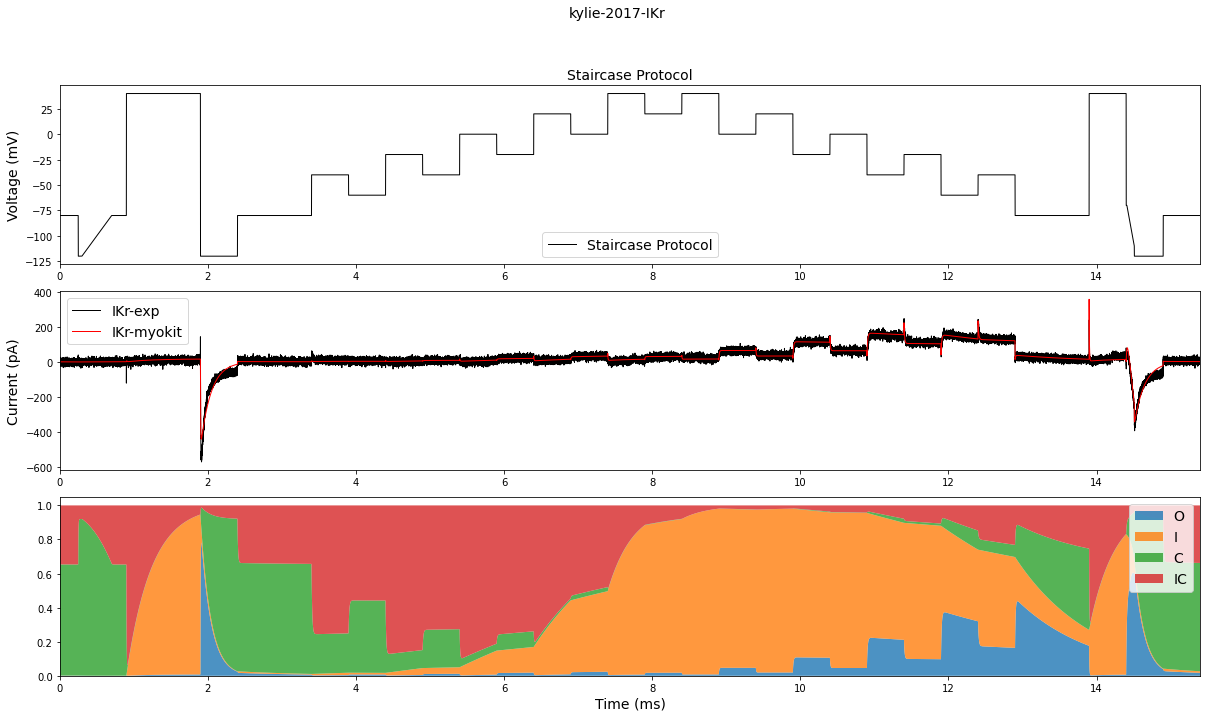

Complete


In [21]:
fig, axes = plt.subplots(3, figsize=(18, 10))
fig.suptitle(sim_myokit.name, fontsize=14)
axes[0].set_title("Staircase Protocol", fontsize=14)
axes[0].set_xlim(0, sim_info.times[-1])
axes[0].set_ylabel("Voltage (mV)", fontsize=14)
axes[0].plot( sim_info.times, sim_info.V*1000, label="Staircase Protocol", linewidth=1, color='k')
# textstr = "GNa : %1.4f\nGNaL : %1.4f\nGto : %1.4f\nPCa : %1.4f\nGKr : %1.4f\nGKs : %1.4f\nGK1 : %1.4f\nGf : %1.4f"%(Gs[0], Gs[1], Gs[2], Gs[3], Gs[4], Gs[5], Gs[6], Gs[7])
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# axes[0].text(0.67, 0.60, textstr, transform=axs[0].transAxes, fontsize=14, verticalalignment='top', bbox=props)    
axes[0].legend(fontsize=14)
axes[0].xaxis.set_visible(True)

axes[1].set_xlim(0, sim_info.times[-1])
axes[1].set_ylabel("Current (pA)", fontsize=14)
axes[1].plot(exp_info.times, exp_info.IKr, label="IKr-exp", linewidth=1, color='k')
axes[1].plot(sim_info.times, sim_info.IKr, label="IKr-myokit", linewidth=1, color='r')
axes[1].legend(fontsize=14)
axes[1].xaxis.set_visible(True)

axes[2].set_xlim(0, sim_info.times[-1])
axes[2].set_xlabel("Time (ms)", fontsize=14)
axes[2].stackplot(sim_info.times, [sim_info.O, sim_info.I, sim_info.C, sim_info.IC], labels=['O', 'I', 'C', 'IC'], alpha=0.8)
axes[2].legend(fontsize=14)
axes[2].xaxis.set_visible(True)

plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.87, wspace=0.5, hspace=0.15)
# fig.tight_layout()#rect=[0.5, 0.5, 0.5, 0.5]
plt.show()
fig.savefig(os.path.join('Results', f"Kylie2017IKr_VC-{exp_info.cell}-{dt}.jpg"), dpi=100)
print("Complete")

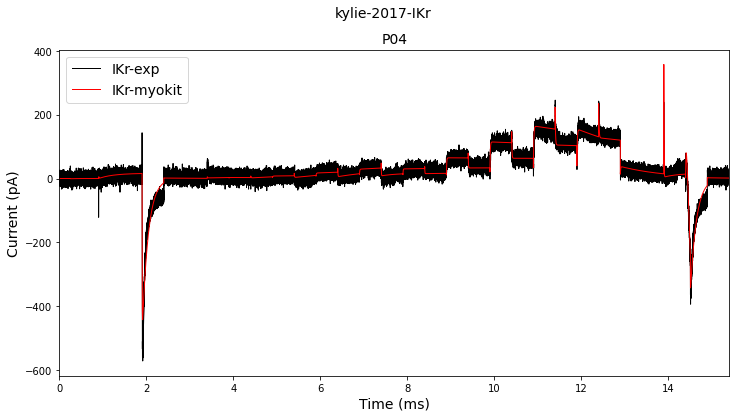

Complete


In [22]:
fig, ax = plt.subplots(1, figsize=(12, 6))
fig.suptitle(sim_myokit.name, fontsize=14)

ax.set_title(f"{exp_info.cell}", fontsize=14)
ax.set_xlabel("Time (ms)", fontsize=14)
ax.set_xlim(0, exp_info.times[-1])
ax.set_ylabel("Current (pA)", fontsize=14)
ax.plot(exp_info.times, exp_info.IKr, label="IKr-exp", linewidth=1, color='k')
ax.plot(sim_info.times, sim_info.IKr, label="IKr-myokit", linewidth=1, color='r')
ax.legend(fontsize=14)
ax.xaxis.set_visible(True)

# plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.87, wspace=0.5, hspace=0.15)
# fig.tight_layout()#rect=[0.5, 0.5, 0.5, 0.5]
plt.show()
fig.savefig(os.path.join('Results', f"I-{exp_info.cell}-{dt}.jpg"), dpi=100)
print("Complete")